In [1]:
import numpy as np
import json
import glob

from neo.io import BlackrockIO
import os, glob
# Get all files ending with 'ccf' in current directory
session_name = os.path.splitext(glob.glob('*.ccf')[0])[0]
blackrock_io = BlackrockIO(filename=f'{session_name}-001.ns5')
blackrock_io.parse_header()
sampling_rate = blackrock_io.header['signal_channels']['sampling_rate'][0]

triggers_DET36A2 = np.load("triggers_DET36A2.npy") / sampling_rate

trial_data_filename = max(glob.glob('trial_data/events/*.json')) # latest trial data file
with open(trial_data_filename, "r") as f:
    trial_events = json.load(f)

    application_start_time = trial_events[0]['time']

    trial_events_DET36A2 = [x for x in trial_events if x['type'] == 'application_start' or x['type'] == 'show_stimulus']
    triggers_DET36A2_task = np.array([x['time'] for x in trial_events_DET36A2])

    trial_events_behavioral = [x for x in trial_events if x['type'] == 'mouse_click']
    triggers_behavioral_task = np.array([x['time'] for x in trial_events_behavioral])

with open(f'trial_data/template.json', "r") as f:
    template = json.load(f)

# Remove the first trigger from triggers_DET36A2_task because it is "application_start" and is before the images start flowing
triggers_DET36A2_task = triggers_DET36A2_task[1:]
triggers_DET36A2 = triggers_DET36A2[1:]
trial_events_DET36A2 = trial_events_DET36A2[1:]

# Align the triggers to the mean of the other triggers
absolute_timing_offset = triggers_DET36A2_task.mean() - triggers_DET36A2.mean()
triggers_DET36A2_task = triggers_DET36A2_task - absolute_timing_offset
triggers_behavioral_task = triggers_behavioral_task - absolute_timing_offset

if len(triggers_DET36A2) != len(triggers_DET36A2_task):
    print(f"Warning: Number of triggers from DET36A2 and DET36A2_task are different: {len(triggers_DET36A2)} and {len(triggers_DET36A2_task)}")

print(f"Loaded {len(triggers_DET36A2)} triggers from DET36A2 and {len(triggers_behavioral_task)} triggers from behavioral task")

Loaded 1920 triggers from DET36A2 and 130 triggers from behavioral task


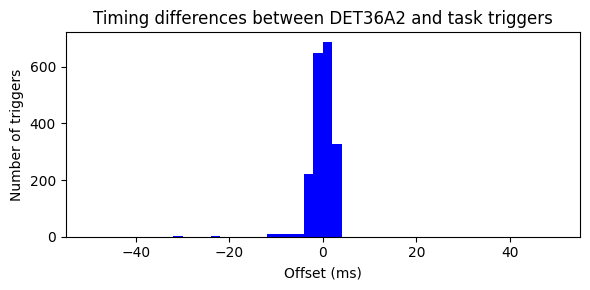

In [2]:
timing_differences = (triggers_DET36A2_task - triggers_DET36A2) * 1000  # convert to milliseconds

display_range = 50 # in ms
if (np.abs(timing_differences).any() > display_range):
    print("Warning: Some timing differences are greater than the display range:")
    print(timing_differences[np.abs(timing_differences) > display_range])
    display_range = np.abs(timing_differences).max()

import matplotlib.pyplot as plt
plt.figure(figsize=(6, 3))
plt.hist(timing_differences, bins=50, range=(-display_range, display_range), color='blue')  # range converted to ms
plt.xlabel('Offset (ms)')
plt.ylabel('Number of triggers')
plt.title('Timing differences between DET36A2 and task triggers')
plt.tight_layout()
plt.show()


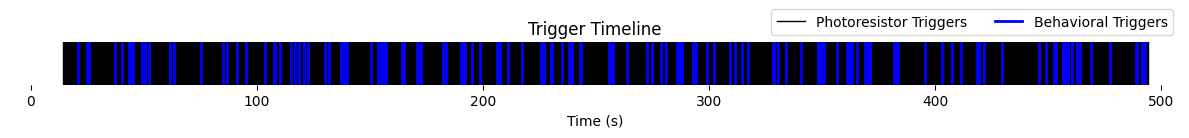

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 1.5))
# Create dummy lines for legend
plt.plot([], [], color='black', linestyle='-', linewidth=1, label='Photoresistor Triggers')
plt.plot([], [], color='blue', linestyle='-', linewidth=2, label='Behavioral Triggers')

for trigger in triggers_DET36A2:
    plt.axvline(x=trigger, color='black', linestyle='-', linewidth=1)

for trigger in triggers_behavioral_task:
    plt.axvline(x=trigger, color='blue', linestyle='-', linewidth=2)

plt.xlabel('Time (s)')
plt.yticks([])  # Remove y-axis
plt.ylim(0, max(max(triggers_DET36A2), max(triggers_behavioral_task)))
plt.title('Trigger Timeline')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower right', ncol=2)
plt.tight_layout()
plt.show()

In [4]:
from temporaldata import IrregularTimeSeries
import h5py

# Grab the image ids from the template, accounting for repeated frames
all_frames = [str(x) for x in template['framedata']]
image_ids = np.zeros(len(triggers_DET36A2))
for trial_event_i, trial_event in enumerate(trial_events_DET36A2):
    image_i = trial_event['meta']['image_i']
    frame = all_frames[image_i]
    image_i = all_frames.index(frame) # get the first index of the frame
    image_ids[trial_event_i] = image_i

images = IrregularTimeSeries(
    timestamps = triggers_DET36A2,  # When stimuli were shown. (n_stimuli,)
    stimulus_ids = image_ids,  # Image identifiers
    timekeys = ['timestamps'],  # Only timestamps should be adjusted during operations
    domain = 'auto'
)
with h5py.File("images.h5", "w") as f:
    images.to_hdf5(f)
print("images = ", images)


images =  IrregularTimeSeries(
  timestamps=[1920],
  stimulus_ids=[1920]
)


In [5]:
trigger_timestamps = np.concatenate([triggers_DET36A2, triggers_behavioral_task])
trigger_types = np.array([x['type'] for x in trial_events_DET36A2] + [x['type'] for x in trial_events_behavioral])
trigger_notes = np.array([str(x['meta']) for x in trial_events_DET36A2] + [str(x['meta']) for x in trial_events_behavioral])

sort_order = np.argsort(trigger_timestamps)
trigger_timestamps = trigger_timestamps[sort_order]
trigger_types = trigger_types[sort_order]
trigger_notes = trigger_notes[sort_order]

triggers = IrregularTimeSeries(
    timestamps = trigger_timestamps,
    trigger_types = trigger_types,
    trigger_notes = trigger_notes,
    timekeys = ['timestamps'],
    domain = 'auto'
)
with h5py.File("triggers.h5", "w") as f:
    triggers.to_hdf5(f)
print("triggers = ", triggers)

triggers =  IrregularTimeSeries(
  timestamps=[2050],
  trigger_types=[2050],
  trigger_notes=[2050]
)
